# 🧪 Lesson 01: Building Graphs

**Series**: Chemical Graph Machine Learning  
**Prerequisites**: Basic Python, fundamental chemistry  
**Next Lesson**: [02 - Positional Encoding](./02_Positional_Encoding.ipynb)  
**Estimated Time**: 45-60 minutes

---

## 📚 Learning Objectives

By the end of this lesson, you will:
1. ✅ Parse SMILES strings into molecular objects
2. ✅ Generate 2D and 3D representations of molecules
3. ✅ Convert molecules into graph structures (nodes and edges)
4. ✅ Extract numerical features for machine learning
5. ✅ Understand how chemistry and graph theory connect

**These skills are foundational for the entire series.**

### Molecular Visualisation and Graph Representation with RDKit

This notebook demonstrates how to work with molecular structures in Python using RDKit, 
visualise them in multiple ways, and extract graph-based representations suitable for 
machine learning applications.

### Prerequisites
This notebook assumes you have:
- Basic Python knowledge (loops, lists, functions)
- Fundamental chemistry (molecular structure, bonds, functional groups)
- No prior experience with RDKit or graph theory required

## Setup and Dependencies

We're using three core libraries:
- **RDKit**: The chemistry toolkit for molecular manipulation and visualisation
- **NetworkX**: For graph theory operations (molecules are graphs!)
- **Matplotlib**: Standard plotting, including 3D visualisations

In [11]:
# Modules from RDKit
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, rdMolAlign
from rdkit.Chem.Draw import rdMolDraw2D

# Plotting and 3D visualisation
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import py3Dmol

# NetworkX for graph operations
import networkx as nx

# IPython for interactive display
from IPython.display import display, SVG

# Data handling
import pandas as pd
import numpy as np


## Loading a Molecule from a SMILES String

### What is SMILES?

SMILES (Simplified Molecular Input Line Entry System) is a compact text notation 
for representing molecular structures. It's like a "compressed file format" for chemistry.

For example: `CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=C(C=C3)O)N)C(=O)O)C` represents a specific organic molecule.

### Parsing and Displaying the Structure

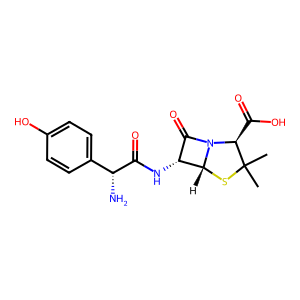

In [12]:
smiles = 'CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=C(C=C3)O)N)C(=O)O)C' # SMILES string for chemical compound, in this case Amoxicillin
molecule = Chem.MolFromSmiles(smiles) # Convert SMILES string to molecule object
img = Draw.MolToImage(molecule) # Convert molecule object to image

# Display image
display(img)

**What's happening here:**
- `MolFromSmiles()` parses the string and creates a molecule object
- RDKit automatically computes 2D coordinates for visualisation
- By default, hydrogens are implicit (not shown) for cleaner diagrams
- This is the standard way chemists draw structures on paper

### Showing Explicit Hydrogens

You can also show the chemical with the hydrogens attached as this isnt done by default.

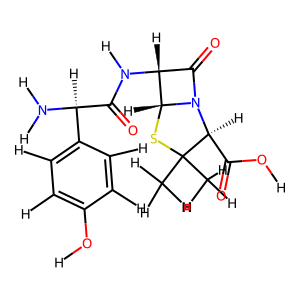

In [13]:
molecule_h = Chem.AddHs(molecule)
img_h = Draw.MolToImage(molecule_h)
display(img_h)

**Why show hydrogens explicitly?**
- Important for understanding stereochemistry and 3D geometry
- Necessary for certain calculations
- In machine learning, you might choose to include or exclude them depending on your task

**Trade-off:** Explicit hydrogens make diagrams cluttered but more chemically complete, as seen in the image above.

### Chemical Highlighting

Images of chemical structures with highlighted atoms can also be generated using the `Draw` module from RDKit.

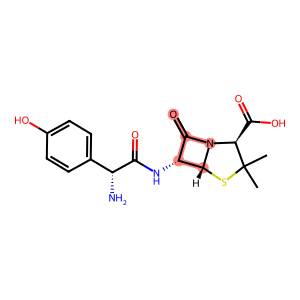

In [14]:

# Define the pattern to search for
patt = Chem.MolFromSmarts('CCC(=O)N')

if patt:
    # Find the substructure match
    hit_ats = molecule.GetSubstructMatch(patt)
    hit_bonds = []
    if hit_ats:
        for bond in patt.GetBonds():
            # Get the atom indices for the bond in the molecule
            aid1 = hit_ats[bond.GetBeginAtomIdx()]
            aid2 = hit_ats[bond.GetEndAtomIdx()]
            # Append the bond index to the list
            hit_bonds.append(molecule.GetBondBetweenAtoms(aid1, aid2).GetIdx())

    d = rdMolDraw2D.MolDraw2DSVG(300, 300)
    # Draw the molecule with highlighted atoms and bonds
    d.DrawMolecule(molecule, highlightAtoms=hit_ats, highlightBonds=hit_bonds)
    d.FinishDrawing()
    display(SVG(d.GetDrawingText()))


**Understanding SMARTS patterns:**
- SMARTS is like SMILES but supports wildcards and logical operators
- `'CCC(=O)N'` matches the Lactam ring in our molecule
- `GetSubstructMatch()` returns the indices of matching atoms

**Why this matters:**
- Substructure searching is fundamental in drug discovery
- You can identify pharmacophores (functional groups responsible for biological activity)
- In ML pipelines, you might use this to generate binary fingerprints

**The algorithm:**
1. Find atoms that match the pattern
2. Identify bonds between matched atoms
3. Render the molecule with highlights

# Graphs and Geometry

Molecules exist in 3D space, but we often need 2D representations for display 
or 3D coordinates for calculations or visualisations that are more representative of the molecule. This section shows how to generate both.

### 2D Depiction Coordinates

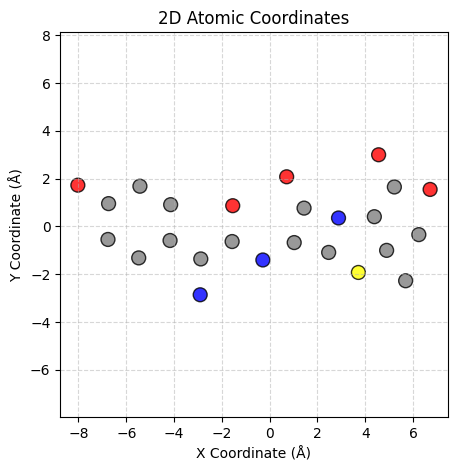

In [15]:
def generate_structure_depiction(mol, template_mol=None):
    """
    Generates 2D coordinates for a molecule, optionally matching a template structure.
    Returns the conformer coordinates.
    """
    # Compute 2D coordinates for the molecule
    AllChem.Compute2DCoords(mol)
    
    # If a template is provided, align the molecule to the template
    if template_mol is not None:
        AllChem.GenerateDepictionMatching2DStructure(mol, template_mol)
        
    # Extract coordinates
    conformer = mol.GetConformer()
    coords = conformer.GetPositions()
    return coords

coords = generate_structure_depiction(molecule)

# Define atom colors (CPK-like)
cpk_colors = {
    'C': 'gray',
    'O': 'red',
    'N': 'blue',
    'S': 'yellow',
    'H': 'lightgray'
}

# Get colors for each atom in the molecule
colors = [cpk_colors.get(atom.GetSymbol(), 'black') for atom in molecule.GetAtoms()]

import matplotlib.pyplot as plt

# Visualise the atomic positions (coordinates are in Angstroms)
plt.figure(figsize=(5, 5))
plt.scatter(coords[:, 0], coords[:, 1], s=100, c=colors, alpha=0.8, edgecolors='black')
plt.title("2D Atomic Coordinates")
plt.xlabel("X Coordinate (Å)")
plt.ylabel("Y Coordinate (Å)")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**What are depiction coordinates?**
- These aren't "real" 3D coordinates from physics
- They're optimised for visual clarity (avoiding overlapping atoms/bonds)
- Think of them as "artistic" coordinates designed for human readability

**The template matching feature:**
- Useful when comparing similar molecules
- Aligns them in the same orientation for easy visual comparison
- Common in medicinal chemistry when showing a series of analogues

**CPK color scheme:**
- Industry standard from Corey, Pauling, and Koltun's physical molecular models
- Carbon = grey/black, Oxygen = red, Nitrogen = blue
- Your brain learns to recognise functional groups by color

**Why scatter plot the coordinates?**
- Shows you the raw coordinate data RDKit is working with
- Useful for debugging layout issues
- In data science, you might analyse coordinate distributions or use them as features

### 3D Ensembles in 2D

**What's a conformational ensemble?**
- Molecules aren't rigid - bonds can rotate
- Each unique 3D arrangement is a "conformer"
- We generate many to understand the molecule's flexibility

**The process:**
1. **ETKDG** (Experimental Torsion Knowledge Distance Geometry): Uses knowledge from crystal structures to generate realistic starting geometries
2. **MMFF optimization**: Minimizes energy using a force field (like a physics simulation)
3. **Alignment**: Overlays all conformers so we can compare them

**Why this matters:**
- Flexible molecules might bind to proteins in multiple ways
- In drug design, you want to know the "bioactive conformation"
- ML models for molecular property prediction often need 3D information

**Chemical insights you can extract:**
- The aromatic ring system (fused rings) should be rigid → tight cloud
- Single bonds allow rotation → you might see wider spreads
- This visualisation is like a "probability distribution" of where atoms can be

**Connection to ML:**
- Conformer generation is crucial for 3D molecular descriptors
- Some models (e.g., for docking) need accurate 3D geometries
- Others might use ensemble statistics as features

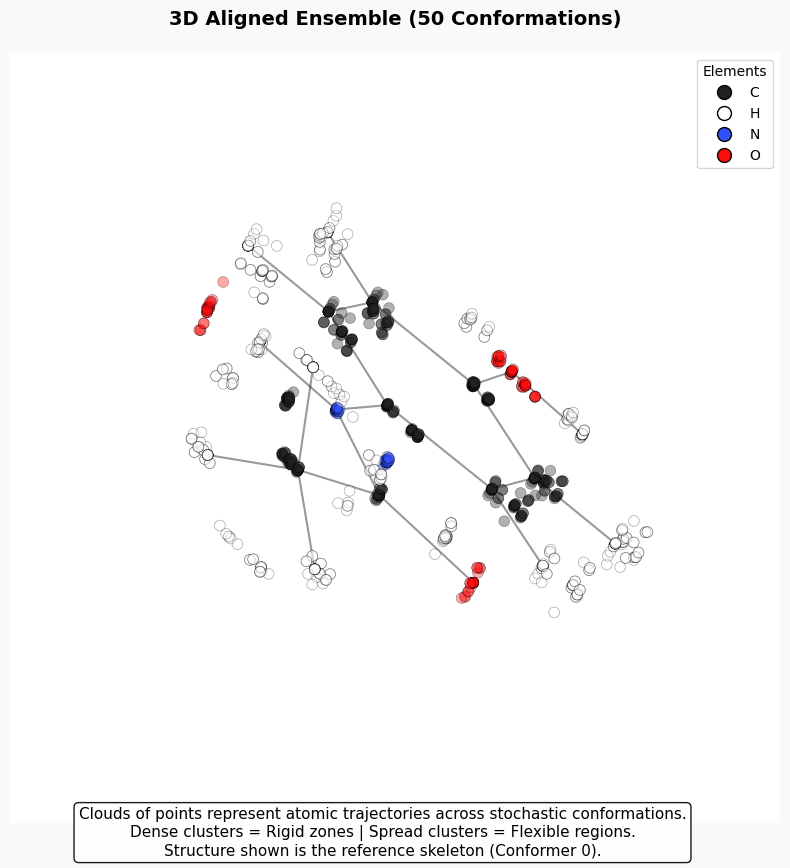

In [16]:
# Define the molecule
smiles = "CC(=O)NC1=CC=C(C=C1)O" # Using a simple molecule for visualisation
molecule = Chem.MolFromSmiles(smiles)

def generate_3d_ensemble(mol, num_confs=50, seed=42):
    """Generates an ensemble of 3D conformations and aligns them."""
    mH = Chem.AddHs(mol)
    params = AllChem.ETKDGv3()
    params.randomSeed = seed
    
    AllChem.EmbedMultipleConfs(mH, numConfs=num_confs, params=params)
    AllChem.MMFFOptimizeMoleculeConfs(mH)
    rdMolAlign.AlignMolConformers(mH)
    return mH

# Generate the aligned ensemble
molecule_3d = generate_3d_ensemble(molecule)

# Element-to-color mapping (Standard CPK colors)
cpk_colors = {
    'C': '#222222', 'O': '#FF0D0D', 'N': '#3050F8', 
    'H': '#FFFFFF', 'S': '#FFFF30', 'P': '#FF8000',
}

fig = plt.figure(figsize=(10, 10), facecolor='#f8f9fa')
ax = fig.add_subplot(111, projection='3d')

# 1. Plot the skeletal bonds for the reference conformer
conf0 = molecule_3d.GetConformer(0)
for bond in molecule_3d.GetBonds():
    idx1, idx2 = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    p1, p2 = conf0.GetAtomPosition(idx1), conf0.GetAtomPosition(idx2)
    ax.plot([p1.x, p2.x], [p1.y, p2.y], [p1.z, p2.z], 
            color='black', alpha=0.4, linewidth=1.5, zorder=1)

# 2. Plot Atomic clouds across the ensemble
atoms = molecule_3d.GetAtoms()
seen_symbols = set()
for i, atom in enumerate(atoms):
    symbol = atom.GetSymbol()
    color = cpk_colors.get(symbol, '#CCCCCC')
    
    # Collect positions for this specific atom across all conformers
    atom_coords = np.array([conf.GetAtomPosition(i) for conf in molecule_3d.GetConformers()])
    
    # Plot the cloud
    ax.scatter(atom_coords[:, 0], atom_coords[:, 1], atom_coords[:, 2], 
               alpha=0.35, c=color, edgecolors='black', s=60, 
               linewidth=0.5, zorder=2)
    seen_symbols.add(symbol)

# 3. Add a Custom Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=s, 
                          markerfacecolor=cpk_colors.get(s, '#CCC'), 
                          markersize=10, markeredgecolor='k') for s in sorted(list(seen_symbols))]
ax.legend(handles=legend_elements, title="Elements", loc='upper right', frameon=True)

# 4. Final Polish
ax.set_title(f"3D Aligned Ensemble ({molecule_3d.GetNumConformers()} Conformations)", 
             fontsize=14, fontweight='bold', pad=20)
ax.view_init(elev=25, azim=35) # Better viewing angle
ax.set_axis_off() # Cleaner look without the box grid

explanation = (
    "Clouds of points represent atomic trajectories across stochastic conformations.\n"
    "Dense clusters = Rigid zones | Spread clusters = Flexible regions.\n"
    "Structure shown is the reference skeleton (Conformer 0)."
)
plt.figtext(0.5, 0.08, explanation, wrap=True, horizontalalignment='center', 
            fontsize=11, fontname='sans-serif', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.show()


## Visualising a 3D Conformer Ensemble (Aligned)

This plot shows a **3D ensemble of 50 conformations** generated from the SMILES string:

`CC(=O)NC1=CC=C(C=C1)O`

### How to read the figure

- **Black/grey bonds** show the **reference “skeleton”** (Conformer 0 only).  
  This provides a fixed scaffold to compare against.

- Each atom is plotted as a **cloud of points**, where each point is that atom’s position in one conformer.  
  After alignment, **cloud size and shape** become a direct visual proxy for flexibility.

- Colours follow standard **CPK element colours**:
  - **C** = dark/black  
  - **H** = white  
  - **N** = blue  
  - **O** = red  

### Flexibility vs rigidity (what the clouds mean)

- **Dense, tight clusters** indicate **rigid regions**.  
  The **aromatic ring** is comparatively stiff, so its atoms tend to cluster tightly.

- **Broader clouds** indicate **flexible regions** (torsions around single bonds, wagging motions, etc.).

- **Separated “islands” of points** (two or more distinct clusters for the same atom) usually indicate **multiple preferred states** (often different rotamers).

### The oxygen “flip” across the molecular plane

One especially informative feature here is the behaviour of the **oxygen atoms (red)**.

After alignment, the aromatic ring acts like a fairly stable reference plane. In the plot, at least one oxygen shows a **split cloud**: red points appear on **both sides of that plane**, rather than forming one single tight cluster. This is a hallmark of a **conformational flip**:

- the local group containing the oxygen (e.g., a substituent attached to the ring) adopts two common orientations,
- those orientations place the oxygen **above vs below** the ring plane (or, more generally, on opposite sides of the aligned molecular scaffold),
- so instead of one “fuzzy blob”, you see **two lobes/islands** of red points.

Mechanistically, this typically comes from **torsion about a single bond** in the substituent (a low-ish barrier rotation). Alignment makes this really obvious: the *core stays put*, and the oxygen’s out-of-plane motion becomes a clean, geometric signal rather than being smeared out by global rotation.

### Why this visualisation is useful

Rather than picking a single “best” conformer, this view answers a better question:

> **Which atoms stay put, and which ones explore multiple geometries?**

Tight clouds highlight rigid cores; wide or split clouds reveal flexible regions and **rotameric / above–below plane switching** (as seen for the oxygen).

## 3D Plotting

Plotting in 3D can be a bit tricky, but it's a powerful tool for understanding molecular structures.
Thankfully, the py3Dmol library makes it easy to visualise molecules in 3D with just a few lines of code.

Here, we'll use it to visualise our molecule in 3D, which is also interactive so you can rotate it and zoom in and out.

In [17]:
view = py3Dmol.view()
view.addModel(Chem.MolToMolBlock(molecule), 'mol')
view.setStyle({'stick': {}, 'sphere': {'scale': 0.3}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**py3Dmol basics:**
- Creates an interactive 3D viewer right in your notebook
- You can rotate, zoom, and inspect the molecule
- `MolToMolBlock()` converts to MOL format (another chemistry file format)

**Style options:**
- `stick`: bonds as cylinders
- `sphere`: atoms as balls (scaled to 30% here for better visibility)
- Other options: cartoon, surface, line, cross

**When to use this:**
- Quick visual inspection during development
- Presenting results in notebooks or reports
- Not suitable for publications (use rendered images instead)


## Graph Traversal

Molecules are naturally graphs: atoms are nodes, bonds are edges. This is perfect 
for graph neural networks (GNNs) and other ML approaches.

**Why NetworkX?**
- Standard library for graph algorithms in Python
- Easy to compute graph properties (centrality, paths, cycles)
- Good for prototyping before moving to specialized GNN libraries

**Stored attributes:**
- **Nodes**: element symbol, atomic number
- **Edges**: bond type (single, double, aromatic, etc.)
- You could add more: charge, hybridization, ring membership, etc.

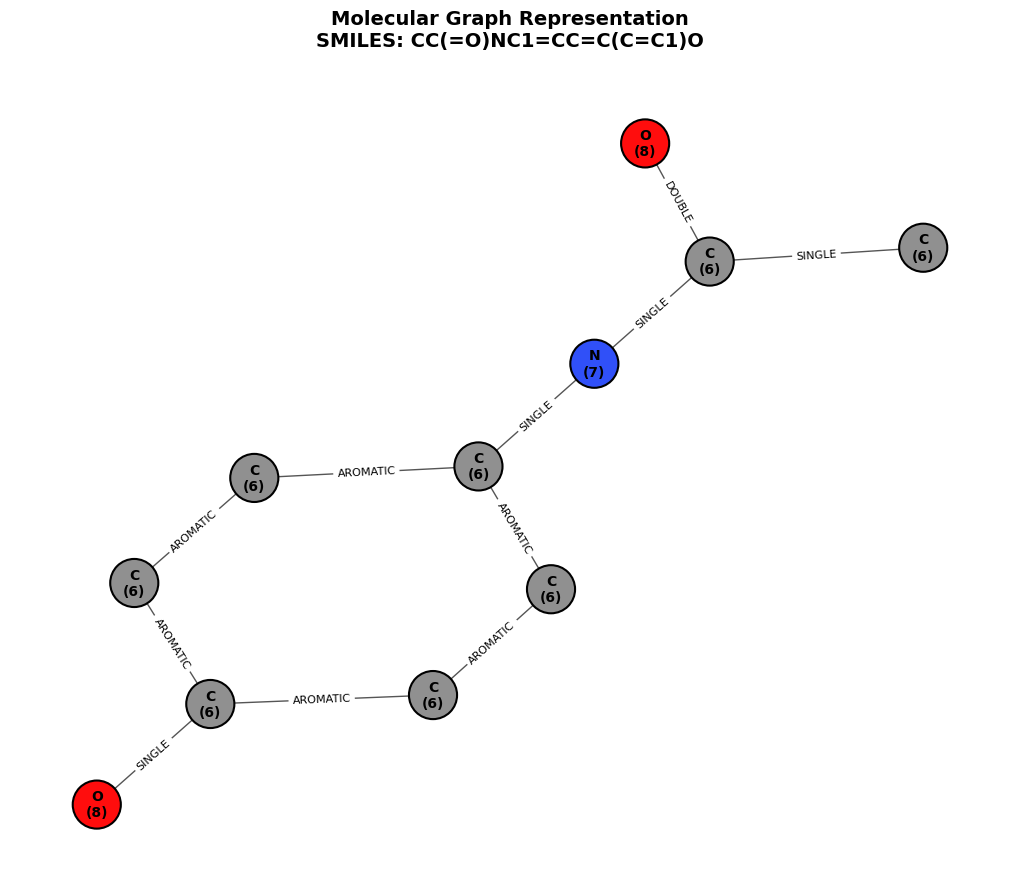

In [18]:
def mol_to_nx(mol: Chem.Mol) -> nx.Graph:
    """Converts an RDKit molecule object into a NetworkX graph with atom and bond metadata."""
    G = nx.Graph()
    
    # Add nodes for each atom with element symbol and atomic number
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   symbol=atom.GetSymbol(),
                   atomic_num=atom.GetAtomicNum())
    
    # Add edges for each bond with bond type information
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType().name)
    return G

# CPK color palette for common atoms (standard molecular visualization colors)
CPK_COLORS = {
    'C': '#909090',  # Carbon - grey
    'O': '#FF0D0D',  # Oxygen - red
    'N': '#3050F8',  # Nitrogen - blue
    'S': '#FFFF30',  # Sulfur - yellow
    'P': '#FF8000',  # Phosphorus - orange
    'F': '#90E050',  # Fluorine - green
    'Cl': '#1FF01F', # Chlorine - bright green
    'Br': '#A62929', # Bromine - dark red
    'I': '#940094',  # Iodine - purple
    'H': '#FFFFFF'   # Hydrogen - white
}

# Convert molecule to graph and calculate node positions
G = mol_to_nx(molecule)
pos = nx.kamada_kawai_layout(G)  # Physics-based layout algorithm

# Extract node attributes
symbols = nx.get_node_attributes(G, 'symbol')
atomic_num = nx.get_node_attributes(G, 'atomic_num')

# Create labels showing element symbol and atomic number
combined_labels = {n: f"{symbols[n]}\n({atomic_num[n]})" for n in G.nodes()}

# Assign colors based on element type (cyan default for unlisted elements)
node_colors = [CPK_COLORS.get(symbols[n], '#00D1FF') for n in G.nodes()]

# Create and configure the plot
plt.figure(figsize=(10, 8))
nx.draw(
    G, pos, 
    labels=combined_labels, 
    with_labels=True, 
    node_color=node_colors, 
    node_size=1200, 
    font_size=10, 
    font_weight='bold',
    edge_color='#555555',  # Dark grey bonds
    linewidths=1.5,
    edgecolors='black'     # Black node outlines
)

# Add bond type labels to edges
edge_labels = nx.get_edge_attributes(G, 'bond_type')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title(f"Molecular Graph Representation\nSMILES: {smiles}", 
          fontsize=14, fontweight='bold', pad=20)
plt.axis('off')
plt.show()

**Kamada-Kawai layout:**
- Force-directed algorithm that positions nodes
- Tries to minimize "energy" by spacing connected nodes evenly
- Won't match the chemical 2D layout, but shows connectivity clearly

**Graph visualization tips:**
- Edge labels show bond types (useful for debugging)
- Colors help identify atom types at a glance
- Node size can encode properties (e.g., atom mass, charge)

**From graphs to ML:**
- This representation is what graph neural networks operate on
- Libraries like PyTorch Geometric or DGL extend this concept
- You'd typically encode node/edge features as vectors

## Feature Engineering for Machine Learning

When training machine learning models on molecular data, we need to convert chemical 
structures into numerical features that algorithms can process. This involves extracting 
relevant atomic properties and structural information from the molecule.

**In this series, you'll use these features to:**
- **Lesson 03**: Build attention mechanisms in Graph Attention Networks (GATs)
- **Lesson 05**: Feed graph transformers for global molecular understanding
- **Lesson 07**: Predict solubility and other chemical properties

The following code builds a feature matrix where each row represents an atom and each 
column represents a specific property. These features capture both intrinsic atomic 
properties (like atomic number and mass) and structural context (like connectivity 
and hybridisation).

### Node Features

The following code builds a feature matrix where each row represents an atom and each column represents a specific property. These features capture both intrinsic atomic properties (like atomic number and mass) and structural context (like connectivity and hybridisation).

In [19]:
# Define column names for the feature matrix
NODE_COLUMNS = [
    'AtomicNumber', 
    'FormalCharge', 
    'IsAromatic', 
    'IsHydrogen', 
    'IsHalogen', 
    'Mass',
    'NumHs',
    'IsIsotope',
    'TotalDegrees',
    'TotalNumValenceElectrons',
    'ChiralTag',
    'Hybridization',
    'Index',
    'IndexNeighbours',
]

def extract_node_features(mol: Chem.Mol) -> pd.DataFrame:
    """
    Extract node (atom) features from an RDKit molecule.
    
    This feature set is used throughout the Chemical Graph series:
    - Lesson 03: GAT node embeddings
    - Lesson 05: Transformer input features
    - Lesson 07: Property prediction models
    
    Returns:
        DataFrame with one row per atom, columns as defined in NODE_COLUMNS
    """
    nodes = []
    
    for atom in mol.GetAtoms():
        atom_features = [
            atom.GetAtomicNum(),                                      
            atom.GetFormalCharge(),                                   
            int(atom.GetIsAromatic()),                                
            int(atom.GetAtomicNum() == 1),                            
            int(atom.GetAtomicNum() in [9, 17, 35, 53]),              
            atom.GetMass(),                                           
            atom.GetTotalNumHs(),                                     
            atom.GetIsotope(),                                        
            atom.GetTotalDegree(),                                    
            atom.GetTotalValence(),                                   
            int(atom.GetChiralTag()),                                 
            int(atom.GetHybridization()),                             
            atom.GetIdx(),                                            
            [neighbor.GetIdx() for neighbor in atom.GetNeighbors()]   
        ]
        nodes.append(atom_features)
    
    return pd.DataFrame(nodes, columns=NODE_COLUMNS)
    
# Create DataFrame with atom features
df_nodes = extract_node_features(molecule)
df_nodes

,AtomicNumber,FormalCharge,IsAromatic,IsHydrogen,IsHalogen,Mass,NumHs,IsIsotope,TotalDegrees,TotalNumValenceElectrons,ChiralTag,Hybridization,Index,IndexNeighbours
0,6,0,0,0,0,12.011,3,0,4,4,0,4,0,[1]
1,6,0,0,0,0,12.011,0,0,3,4,0,3,1,"[0, 2, 3]"
2,8,0,0,0,0,15.999,0,0,1,2,0,3,2,[1]
3,7,0,0,0,0,14.007,1,0,3,3,0,3,3,"[1, 4]"
4,6,0,1,0,0,12.011,0,0,3,4,0,3,4,"[3, 5, 9]"
5,6,0,1,0,0,12.011,1,0,3,4,0,3,5,"[4, 6]"
6,6,0,1,0,0,12.011,1,0,3,4,0,3,6,"[5, 7]"
7,6,0,1,0,0,12.011,0,0,3,4,0,3,7,"[6, 8, 10]"
8,6,0,1,0,0,12.011,1,0,3,4,0,3,8,"[7, 9]"
9,6,0,1,0,0,12.011,1,0,3,4,0,3,9,"[8, 4]"


This feature matrix can now be used as input for various machine learning tasks such as:
- **Property prediction**: predicting molecular properties (solubility, toxicity, binding affinity)
- **Graph neural networks**: where the `IndexNeighbours` column defines the graph connectivity
- **Molecular classification**: distinguishing between different compound classes

Note that the `IndexNeighbours` column contains lists rather than single values, which may require further processing (e.g., creating an adjacency matrix) depending on your chosen ML architecture.

### Edge Features

While nodes represent atoms, edges represent the chemical bonds between them. Bond properties are critical for understanding molecular structure and reactivity, particularly for graph neural networks where message passing occurs along these edges.

In [20]:
# Define column names for the edge feature matrix
EDGE_COLUMNS = ['BeginAtom', 'EndAtom', 'BondType']

def extract_edge_features(mol: Chem.Mol) -> pd.DataFrame:
    """
    Extract edge (bond) features from an RDKit molecule.
    
    These features are critical for:
    - Message passing in GNNs (Lesson 03)
    - Edge attention in transformers (Lesson 05)
    - Understanding molecular connectivity
    
    Returns:
        DataFrame with one row per bond
    """
    edges = []
    
    for bond in mol.GetBonds():
        bond_features = [
            bond.GetBeginAtomIdx(),      
            bond.GetEndAtomIdx(),        
            int(bond.GetBondType())      
        ]
        edges.append(bond_features)
    
    return pd.DataFrame(edges, columns=EDGE_COLUMNS)

# Create DataFrame with bond features
df_edges = extract_edge_features(molecule)
df_edges

,BeginAtom,EndAtom,BondType
0,0,1,1
1,1,2,2
2,1,3,1
3,3,4,1
4,4,5,12
5,5,6,12
6,6,7,12
7,7,8,12
8,8,9,12
9,7,10,1


**Bond type encoding:**
- SINGLE = 1
- DOUBLE = 2
- TRIPLE = 3
- AROMATIC = 12

**Additional features you could add:**
- `bond.IsInRing()` - ring membership (important for strain and stability)
- `bond.GetIsConjugated()` - conjugation (affects electronic properties and reactivity)
- `bond.GetStereo()` - stereochemistry (E/Z or cis/trans isomerism)

**How this connects to GNNs:**
- In message passing, edge features modulate how information flows between nodes
- Bond type is particularly important since single bonds allow rotation whilst double bonds are rigid
- The `BeginAtom` and `EndAtom` indices define the graph adjacency structure
- Edge features can be concatenated with node features during message passing operations

## 🔮 Preview: What's Next

You've now mastered the fundamentals of molecular representation. In the upcoming lessons, 
you'll build increasingly sophisticated models:

### Lesson 02: Positional Encoding
*Why it matters*: Graph neural networks have no inherent sense of "position". You'll learn 
how to encode structural information using spectral methods—giving your GNN spatial awareness.

**You'll need from today:**
- The `IndexNeighbours` column for building Laplacian matrices
- Graph structure to compute eigenvectors
- Understanding that molecules are graphs, not just pictures

### Lesson 03: Graph Attention Networks
*Why it matters*: Not all bonds are equally important. GATs let the model learn which 
connections matter most for prediction.

**You'll need from today:**
- Node features (the DataFrame we just created)
- Edge features (bond types, ring membership)
- NetworkX → PyTorch Geometric conversion

### The Payoff (Lesson 07)
All of this builds toward **predicting real molecular properties** like solubility 
and permeability—critical for drug discovery. By the end, you'll train models that 
can predict these from SMILES strings alone.

## ✅ Knowledge Checkpoint

Before moving to Lesson 02, ensure you can:

- [ ] Explain what SMILES notation represents
- [ ] Convert a SMILES string to a molecule object
- [ ] Describe why molecules are graphs (atoms = nodes, bonds = edges)
- [ ] Extract node and edge features from a molecule
- [ ] Visualise a molecule in 2D and 3D

**Self-test**: Take a different molecule (try aspirin: `CC(=O)Oc1ccccc1C(=O)O`) and:
1. Generate all the visualisations we created
2. Extract node and edge features
3. Identify the aromatic ring in the NetworkX plot

If you can do this, you're ready for Lesson 02!

## Summary

This notebook covered:
1. ✅ Loading and visualizing molecules from SMILES
2. ✅ 2D depiction and 3D conformer generation
3. ✅ Graph representation with NetworkX
4. ✅ Feature extraction for ML models

## Additional Actions

Now that you understand molecular representation, you could:

1. **Build a property predictor**: Use these features with scikit-learn to predict molecular properties
2. **Implement a GNN**: Try PyTorch Geometric with your graph representations
3. **Explore molecular similarity**: Use RDKit fingerprints for similarity searching
4. **Process real datasets**: Download ChEMBL or PubChem data and analyze at scale

**Suggested resources:**
- RDKit documentation: https://www.rdkit.org/docs/
- PyTorch Geometric tutorials: https://pytorch-geometric.readthedocs.io/
- DeepChem for drug discovery ML: https://deepchem.io/